# Volume 3: K-Means Clustering.
    Ben Christensen
    Math 405
    March 19, 2019

In [1]:
from matplotlib import pyplot as plt
from matplotlib.cm import rainbow
from mpl_toolkits.mplot3d import Axes3D# You might want this for Problem 2.
import numpy as np
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, ClusterMixin
from scipy import linalg as la
import os
%matplotlib inline

In [2]:
plt.rcParams["figure.dpi"] = 200

## Problem 1

Write a `KMeans` class for doing basic $k$-means clustering.
Implement the following methods, following `sklearn` class conventions.
1. `__init__()`: Accept a number of clusters $k$, a maximum number of iterations, and a convergence tolerance.
Store these as attributes.

2. `fit()`: Accept an $m \times n$ matrix $X$ of $m$ data points with $n$ features.
Choose $k$ random rows of $X$ as the initial cluster centers.
Run the $k$-means iteration until consecutive centers are within the convergence tolerance, or until iterating the maximum number of times.
Save the cluster centers as attributes.
If a cluster is empty, reassign the cluster center as a random row of $X$.

3. `predict()`: Accept an $l \times n$ matrix $X$ of data.
Return an array of $l$ integers where the $i$th entry indicates which cluster center the $i$th row of $X$ is closest to.

Test your class on the iris data set (`sklean.datasets.load_iris()`) after reducing the data to two principal components (with `sklearn.decomposition.PCA`).
Plot the data, coloring by cluster.

In [27]:
class KMeans(BaseEstimator, ClusterMixin):
    """Basic k-means clustering class."""
    def __init__(self, n_clusters=8, max_iter=100, tol=1e-5, normalize=False):
        """Store clustering algorithm parameters.
        
        Parameters:
            n_clusters (int): How many clusters to compute.
            max_iter (int): The maximum number of iterations to compute.
            tol (float): The convergence tolerance.
        """
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.normalize = normalize        # This is for Problem 2.
        self.centers = None
    
    def fit(self, X, y=None):
        """Compute the cluster centers from random initial conditions.
        
        Parameters:
            X ((n_samples, n_classes) ndarray): the data to be clustered.
        """
        initials_indices = np.random.choice(len(X), self.n_clusters)
        #Choose n_clusters # random rows of X to be the initial
        #    centers of the clusters
        initial_centers = X[initials_indices]
        self.centers = initial_centers
        
        #Normalize cluster centers if normalize is true
        if self.normalize:
            self.centers /= la.norm(self.centers, axis=1).reshape((-1,1))
            
        for i in range(self.max_iter):
            norms = []
            for center in self.centers:
                #Calculate ||x_i - mu_j|| for each i, j
                norms.append(la.norm(X-center, axis=1))
            #Change norms to one array so that we can find argmin
            norms = np.vstack([norm for norm in norms])
            #Find which cluster center is closest to each datapoint
            mask = np.argmin(norms,axis=0)
            #Use the argmin to assign each point to it's closest cluster-center
            clusters = [X[mask==i] for i in range(self.n_clusters)]
            #If a cluster is empty, give it a random data point
            for i, cluster in enumerate(clusters):
                if cluster.shape[0] == 0:
                    clusters[i] = X[np.random.choice(len(X))]
            new_centers = np.array([np.mean(cluster, axis=0) for cluster in clusters])
            #Check if all the cluster centers changed less than the tolerance
            if np.max(la.norm(new_centers - self.centers)) < self.tol:
                self.centers = new_centers
                break

            #Update cluster centers    
            self.centers = new_centers
            
            #Normalize cluster centers if normalize is true
            if self.normalize:
                self.centers = self.centers / la.norm(self.centers, axis=1).reshape((-1,1))
            
        return self
    
    def predict(self, X):
        """Classify each entry of X based on which cluster center it belongs to.

        Parameters:
            X ((n_samples, n_classes) ndarray): the data to be clustered.
        
        Returns:
            ((n_samples) ndarray): Integer labels from 0 to n_clusters for each entry of X.
        """
        norms = []
        for center in self.centers:
            #Calculate ||x_i - mu_j|| for each i, j
            norms.append(la.norm(X-center, axis=1))
        #Change norms to one array so that we can find argmin
        norms = np.vstack([norm for norm in norms])
        #Find which cluster center is closest to each datapoint
        mask = np.argmin(norms,axis=0)
        return mask
    
    def fit_predict(self, X, y=None):
        """Fit to the data and return the resulting labels.

        Parameters:
            X ((n_samples, n_classes) ndarray): the data to be clustered.
        """
        return self.fit(X).predict(X)

In [13]:
iris = load_iris()
y = iris.target
#Reduce to two primary components
X = PCA(n_components=2).fit_transform(iris.data)
#Find prediction with KMeans
mask = KMeans(n_clusters=3).fit_predict(X)

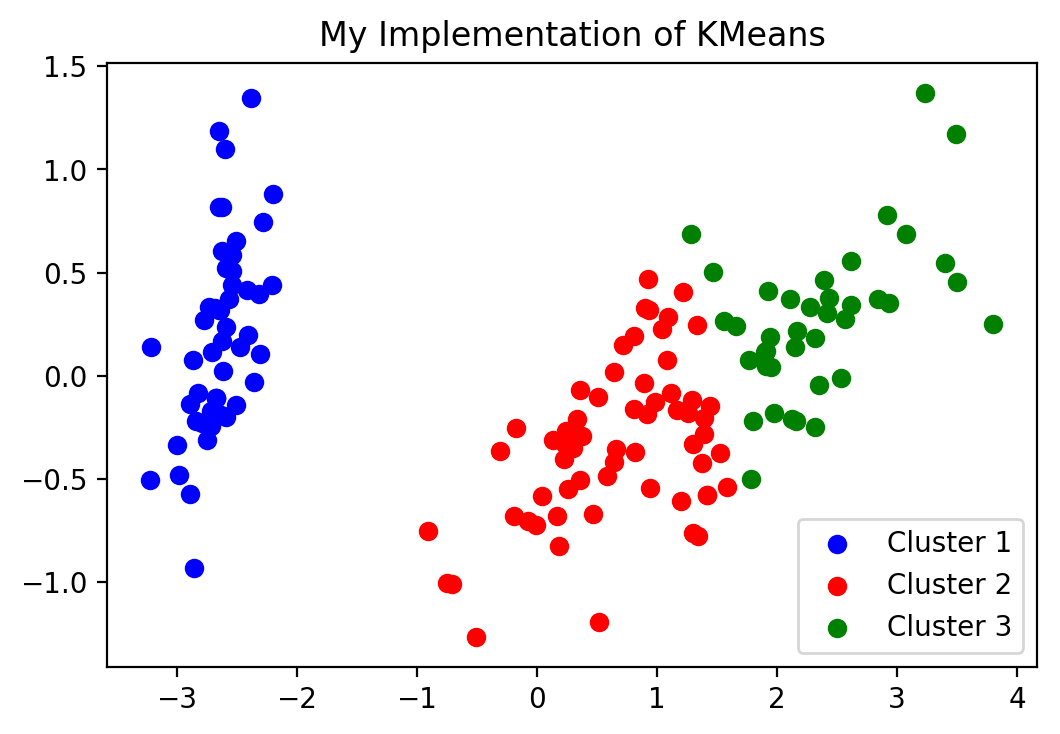

In [5]:
#Plot three clusters
colors = ['blue', 'red', 'green']
for i in range(len(colors)):
    points = X[mask==i]
    plt.scatter(points[:,0], points[:,1], color = colors[i], label=f"Cluster {i+1}")
plt.title("My Implementation of KMeans")
plt.legend()
plt.show()

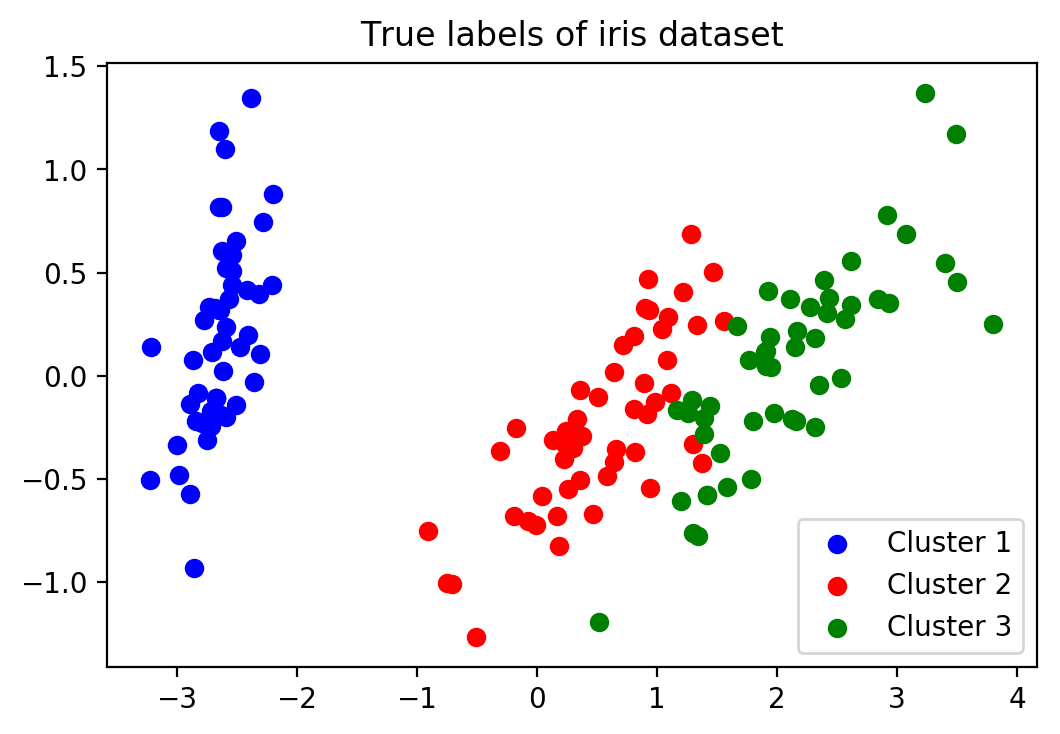

In [6]:
#Plot true labeled data
colors = ['blue', 'red', 'green']
for i in range(len(colors)):
    points = X[y==i]
    plt.scatter(points[:,0], points[:,1], color = colors[i], label=f"Cluster {i+1}")
plt.title("True labels of iris dataset")
plt.legend()
plt.show()

## Problem 2

Modify `KMeansfit()` so that if `normalize` is `True`, the cluster centers are normalized at each iteration.

Cluster the earthquake data in three dimensions by converting the data from spherical coordinates to euclidean coordinates on the sphere.
1. Convert longitude and latitude to radians, then to spherical coordinates.
(Hint: `np.deg2rad()` may be helpful.)
2. Convert the spherical coordinates to euclidean coordinates in $\mathbb{R}^3$.
3. Use your `KMeans` class with normalization to cluster the euclidean coordinates.
4. Translate the cluster center coordinates back to spherical coordinates, then to degrees.
5. Plot the data, coloring by cluster.
Also mark the cluster centers.

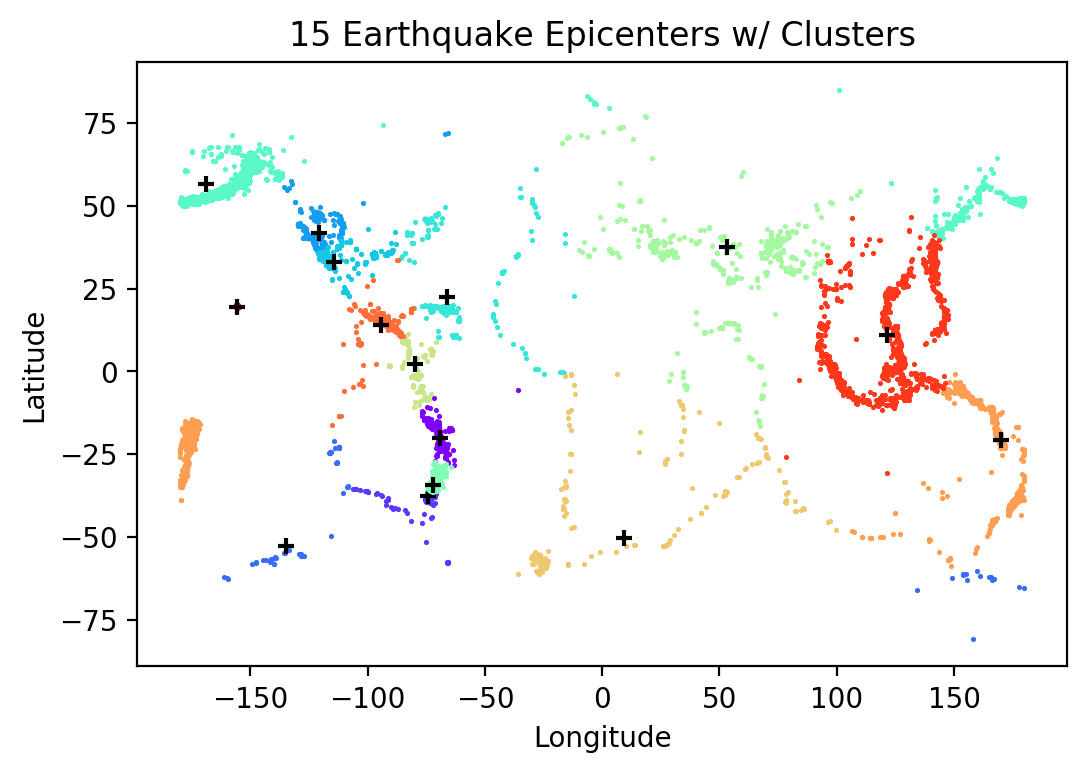

In [7]:
data = np.load("earthquake_coordinates.npy")
#Change longitude and latitude to spherical coordinates
theta = (np.pi / 180)*data[:,0]
phi = (np.pi/180)*(90 - data[:,1])
#Change spherical coordinates to Euclidean coordinates
x = np.sin(phi)*np.cos(theta)
y = np.sin(phi)*np.sin(theta)
z = np.cos(phi)
#Create data to feed into KMeans from the Euclidean coordinates
X = np.hstack((x.reshape((-1,1)), y.reshape((-1,1)), z.reshape((-1,1))))
model = KMeans(n_clusters=15, normalize=True)
mask = model.fit_predict(X)
centers = model.centers
#Convert cluster centers to spherical coordinates
c_phi = np.array([np.arccos(element) for element in centers[:,2]])
c_theta = np.array([np.arctan2(element1,element2) for element1,element2 in zip(centers[:,1],centers[:,0])])
#Convert spherical coordinates to longitude and latitude
c_longitude = (180/np.pi)*c_theta
c_latitude = 90 - (180/np.pi)*c_phi
#Choose colors for the pretty plot
colors = rainbow(np.linspace(0, 1, 15))
for i in range(15):
    #Plot the points from the cluster
    points = data[mask==i]
    plt.scatter(points[:,0], points[:,1], s = .75, color = colors[i])
    #Plot cluster center
    plt.scatter(c_longitude[i], c_latitude[i], color = 'black', marker='+')

plt.title("15 Earthquake Epicenters w/ Clusters")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

## Problem 3

Write a function that accepts an image array (of shape $(m,n,3)$), an integer number of clusters $k$, and an integer number of samples $S$.
Reshape the image so that each row represents a single pixel.
Choose $S$ pixels to train a $k$-means model on with $k$ clusters.
Make a copy of the original picture where each pixel has the same color as its cluster center.
Return the new image.
For this problem, you may use `sklearn.cluster.KMeans` instead of your `KMeans` class.

Test your function on some of the provided NASA images.

In [8]:
def quantize_image(im, n_clusters=4, n_samples=50):
    """Cluster the pixels of the image 'im' by color.
    Return a copy of the image where each pixel is replaced by the value
    of its cluster center.
    
    Parameters:
        im ((m,n,3) ndarray): an image array.
        n_clusters (int): the number of k-means clusters.
        n_samples (int): the number of pixels to train the k-means model on.
    
    Returns:
        ((m,n,3) ndarray): the quantized image.
    """
    #Reshape so that each row of A is a pixel
    m,n = im.shape[0], im.shape[1]
    A = np.copy(im)
    A = np.reshape(A, (m*n,3))
    #Create a random subsample of A to train KMeans on 
    X = A[np.random.choice(np.arange(A.shape[0]), n_samples)]
    model = KMeans(n_clusters=n_clusters)
    #Train on the sample
    model.fit(X)
    #Predict clusters on the full image
    mask = model.predict(A)
    #Change the color of every pixel to be the average color of its
    #    cluster
    centers = model.centers
    for i in range(len(centers)):
        A[mask==i] = centers[i]
    
    #Return image in original shape
    return np.reshape(A, (m,n,3))

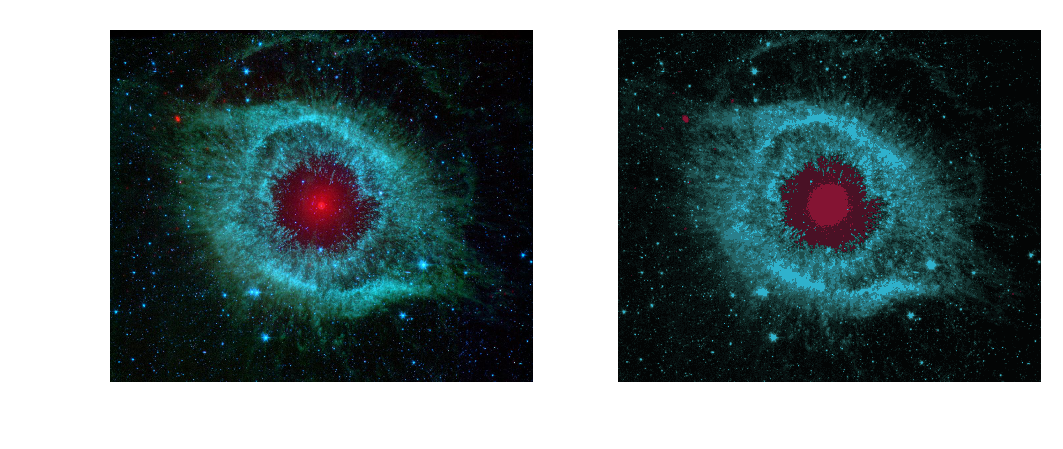

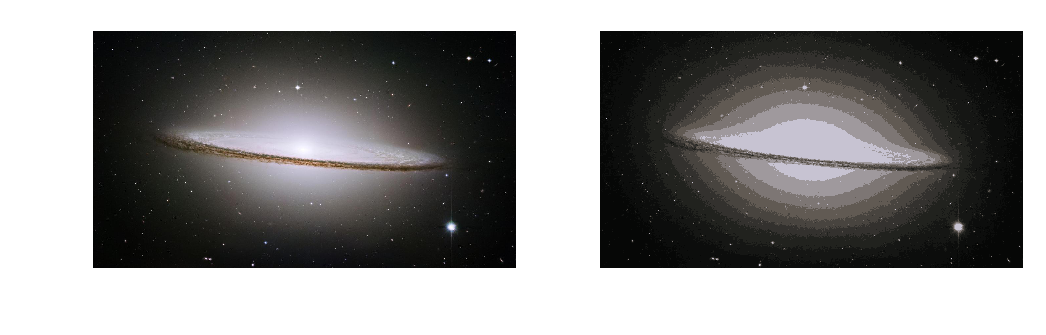

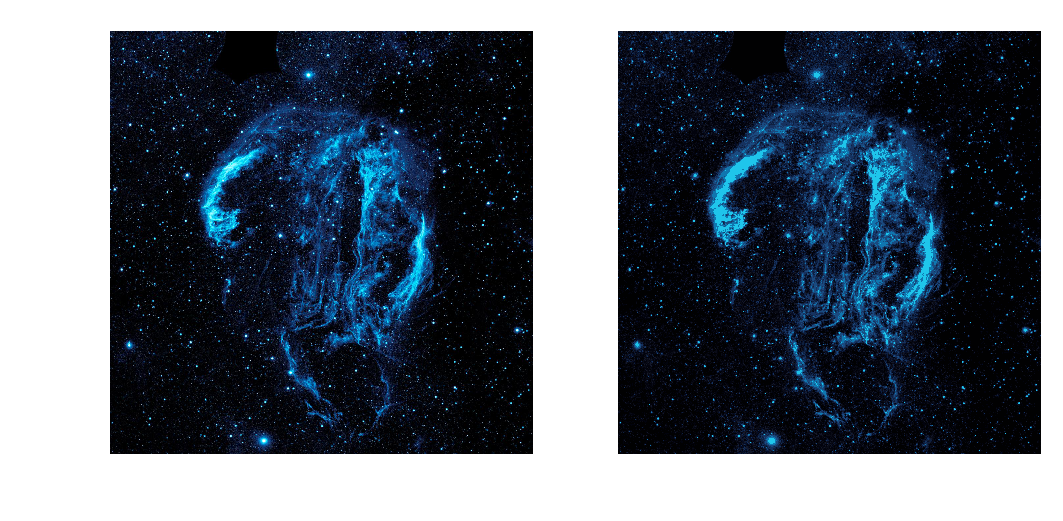

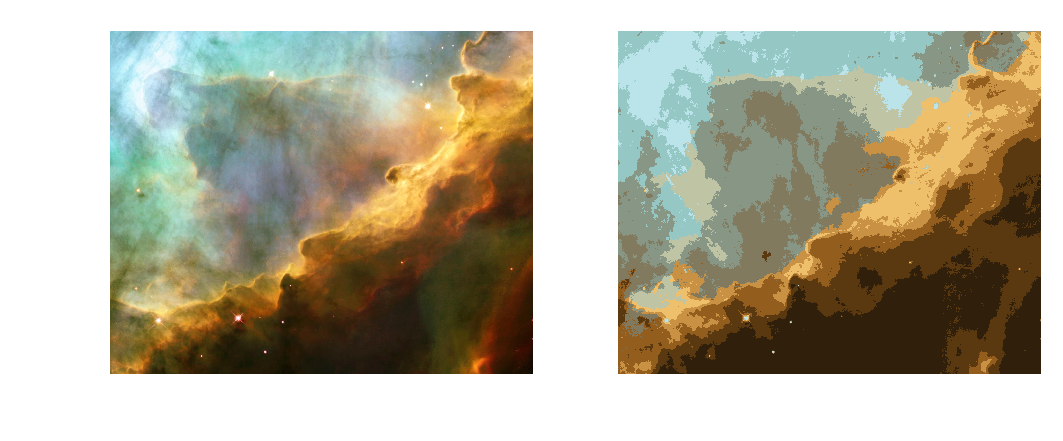

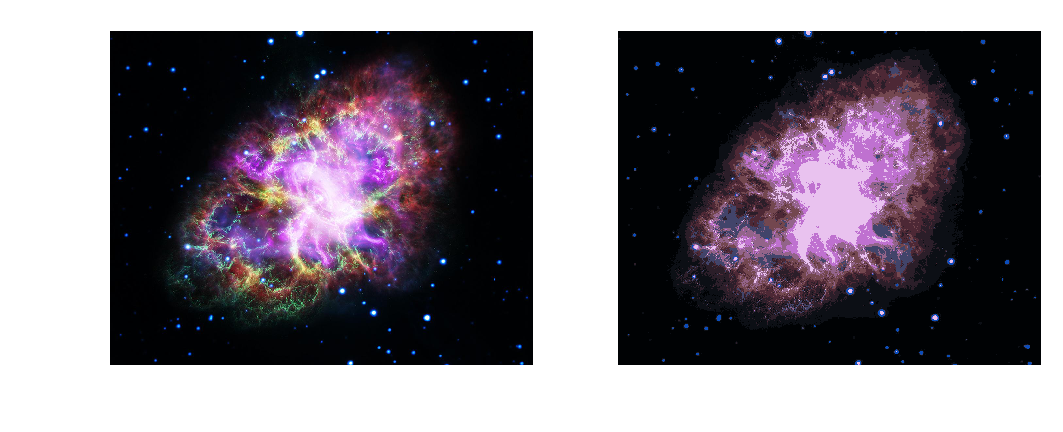

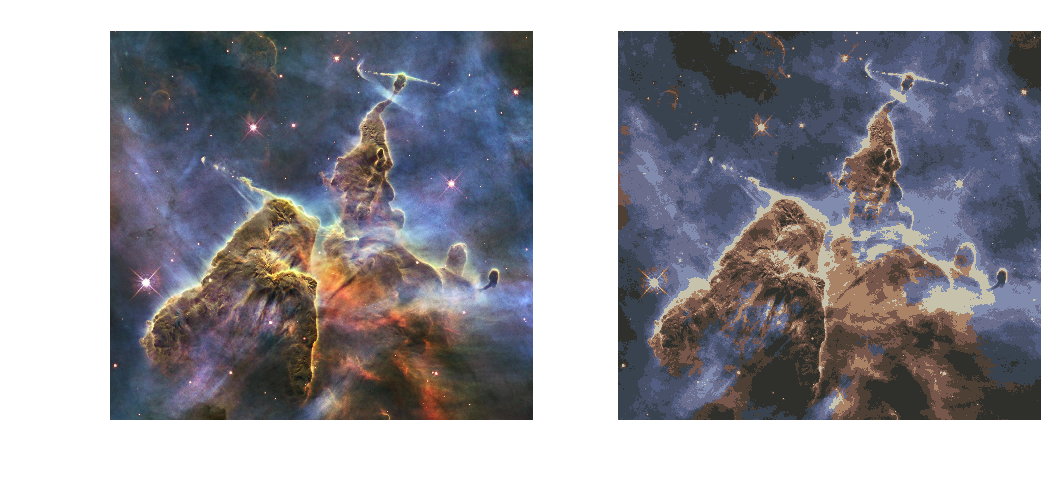

In [31]:
#read in the images
images = [plt.imread('./nasa/' + file) for file in os.listdir('./nasa/')]
for image in images:
    #Plot original image side-by-side with...
    plt.subplot(121)
    plt.imshow(image)
    plt.axis('off')
    #    ... plot of 'compressed' image
    plt.subplot(122)
    plt.imshow(quantize_image(image,n_clusters=10, n_samples=800))
    plt.axis('off')
    plt.show()
